# Energy-based GAN (EBGAN)

## Theory

EBGAN views the discriminator as an **energy function** that attributes low energies to the regions near the data manifold and higher energies to other regions. Similar to the probabilistic GANs, a generator is seen as being trained to produce contrastive samples with minimal energies, while the discriminator is trained to assign high energies to these generated samples. Viewing the discriminator as an energy function allows to use a wide variety of architectures and loss functionals in addition to the usual binary classifier with logistic output.

Given a positive margin $m$, a data sample $x$ and a generated sample $G(z)$, the discriminator loss $\mathcal{L}_D$ and the generator loss $\mathcal{L}_G$ are formally defined by:

$$\mathcal{L}_D(x, z) = D(x) + [m - D(G(z))]^+$$

$$\mathcal{L}_G(z) = D(G(z))$$

where $[\cdot]^+ = \max(0, \cdot)$. Minimizing $\mathcal{L}_G$ with respect to the parameters of $G$ is similar to maximizing the second term of $\mathcal{L}_D$. It has the same minimum but non-zero gradients when $D(G(z)) \ge m$.


## Advantages and Limitations

+ Exhibit more stable behavior than regular GANs during training. 
+ A single-scale architecture can be trained to generate high-resolution images.

## References

J. Zhao, M. Mathieu and Y. LeCun, Energy-based Generative Adversarial Networks, ICLR 2017.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 1e-3
m = 5

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., Multi-Layer Perceptrons (MLP), ConvNets or AutoEncoders. Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    x_recon = tf.matmul(D_h1, D_W2) + D_b2
    mse = tf.reduce_mean(tf.reduce_sum((x - x_recon)**2, 1))
    
    return mse

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Loss functions: use the max-plus algebra
+ We can use some optimization algorithms with different learning rates

In [10]:
D_loss = D_real + tf.maximum(0., m - D_fake)
G_loss = D_fake

D_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $k = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-EBGAN/'):
    os.makedirs('GAN-EBGAN/')

avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_mb = sample_Z(mb_size, Z_dim)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-EBGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 264.5
G_loss: 479.7


Iter: 1000
D_loss: 26.33
G_loss: 4.907


Iter: 2000
D_loss: 24.06
G_loss: 5.143


Iter: 3000
D_loss: 21.21
G_loss: 5.484


Iter: 4000
D_loss: 19.34
G_loss: 5.958


Iter: 5000
D_loss: 16.85
G_loss: 5.516


Iter: 6000
D_loss: 16.62
G_loss: 5.297


Iter: 7000
D_loss: 16.33
G_loss: 5.641


Iter: 8000
D_loss: 14.59
G_loss: 5.725


Iter: 9000
D_loss: 14.26
G_loss: 4.903


Iter: 10000
D_loss: 14.87
G_loss: 5.655


Iter: 11000
D_loss: 13.04
G_loss: 5.818


Iter: 12000
D_loss: 13.48
G_loss: 5.411


Iter: 13000
D_loss: 13.02
G_loss: 5.35


Iter: 14000
D_loss: 13.11
G_loss: 4.831


Iter: 15000
D_loss: 12.82
G_loss: 5.343


Iter: 16000
D_loss: 13.54
G_loss: 6.324


Iter: 17000
D_loss: 12.31
G_loss: 5.269


Iter: 18000
D_loss: 13.59
G_loss: 5.376


Iter: 19000
D_loss: 13.41
G_loss: 4.739


Iter: 20000
D_loss: 14.17
G_loss: 5.181


Iter: 21000
D_loss: 12.79
G_loss: 5.18


Iter: 22000
D_loss: 13.24
G_loss: 5.757


Iter: 23000
D_loss: 13.55
G_loss: 5.248


Iter: 2

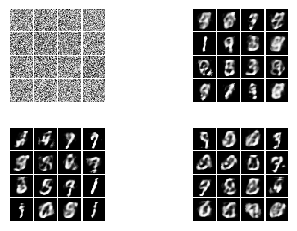

In [12]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-EBGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-EBGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-EBGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-EBGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

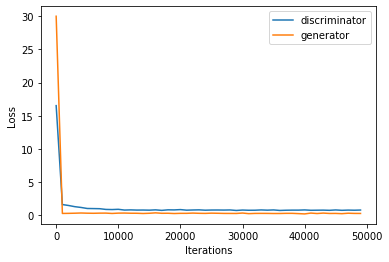

In [13]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()